# Chapter 6 - LIME Image Explanations

Local Interpretable Model-agnostic Explanations (LIME) is a popular local approximation and perturbation-based framework that provides post-hoc explanations for individual predictions. It performs perturbations on a local neighborhood of an instance to learn interpretable sparse linear models as explanations. LIME also provides qualitative explanations for a model’s prediction by highlighting relationships between an instance’s elements in textual and visual artifacts.

For reference, this notebook is tested with TensorFlow 2.3.2 and Python 3.7.10 using Amazon SageMaker Studio ml.m5.4xlarge general-purpose instance with 16 vCPU and 64 GiB. [Link](https://aws.amazon.com/sagemaker/pricing/) for instance pricing reference. Alternatively, you can try this on your preferred IDE.

In [2]:
!pip install scikit-image lime 

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline

from tensorflow import keras 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import inception_v3 as incv3
from tensorflow.keras.applications.imagenet_utils import decode_predictions

import tensorflow as tf
from skimage.io import imread
import os
import matplotlib.pyplot as plt
import numpy as np
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from platform import python_version

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

print(f'TensorFlow version: {tf.__version__}')
print(f'Python version: {python_version()}')

TensorFlow version: 2.3.2
Python version: 3.7.10


/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load a Model

Use a Inception V3 pretrained model to make predictions. Default input image size of Inception-v3 is 299×299.

[2022-12-16 00:29:21.856 tensorflow-2-3-cpu-p-ml-m5-4xlarge-885707fc9223e4cb8db74f111314:4297 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-16 00:29:21.997 tensorflow-2-3-cpu-p-ml-m5-4xlarge-885707fc9223e4cb8db74f111314:4297 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


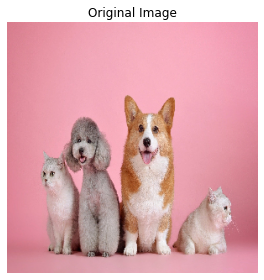

In [4]:
model = incv3.InceptionV3()

def load_process_img(path):
    images = []
    for img_path in path:
        img = image.load_img(img_path, target_size=(299, 299))
        m = image.img_to_array(img)
        m = np.expand_dims(m, axis=0)
        m = incv3.preprocess_input(m)
        images.append(m)
    return np.vstack(images)

images = load_process_img([os.path.join('data','pets.jpg')])

plt.imshow(images[0] / 2 + 0.5)
plt.axis('off')
plt.title("Original Image", fontsize=12)
plt.tight_layout()

## Make Predictions

Obtain predictions for top 5 classes.

In [5]:
preds = model.predict(images)
print('Top 5 classes:')
for im in decode_predictions(preds)[0]:
    print(im)

Top 5 classes:
('n02113023', 'Pembroke', 0.2845333)
('n02342885', 'hamster', 0.09641136)
('n04399382', 'teddy', 0.020572992)
('n02113186', 'Cardigan', 0.011049577)
('n02094258', 'Norwich_terrier', 0.010510633)


## Explain image classifiers

Use LimeImageExplainer to explaine an image classifier

In [6]:
# Explaining classifiers that use Image data

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0], model.predict, top_labels=5, hide_color=0, num_samples=1000)

100%|██████████| 1000/1000 [00:26<00:00, 38.21it/s]


## Explanations for Top Classes

View superpixels that positively contributing to the label predictions with the rest of the image hidden.

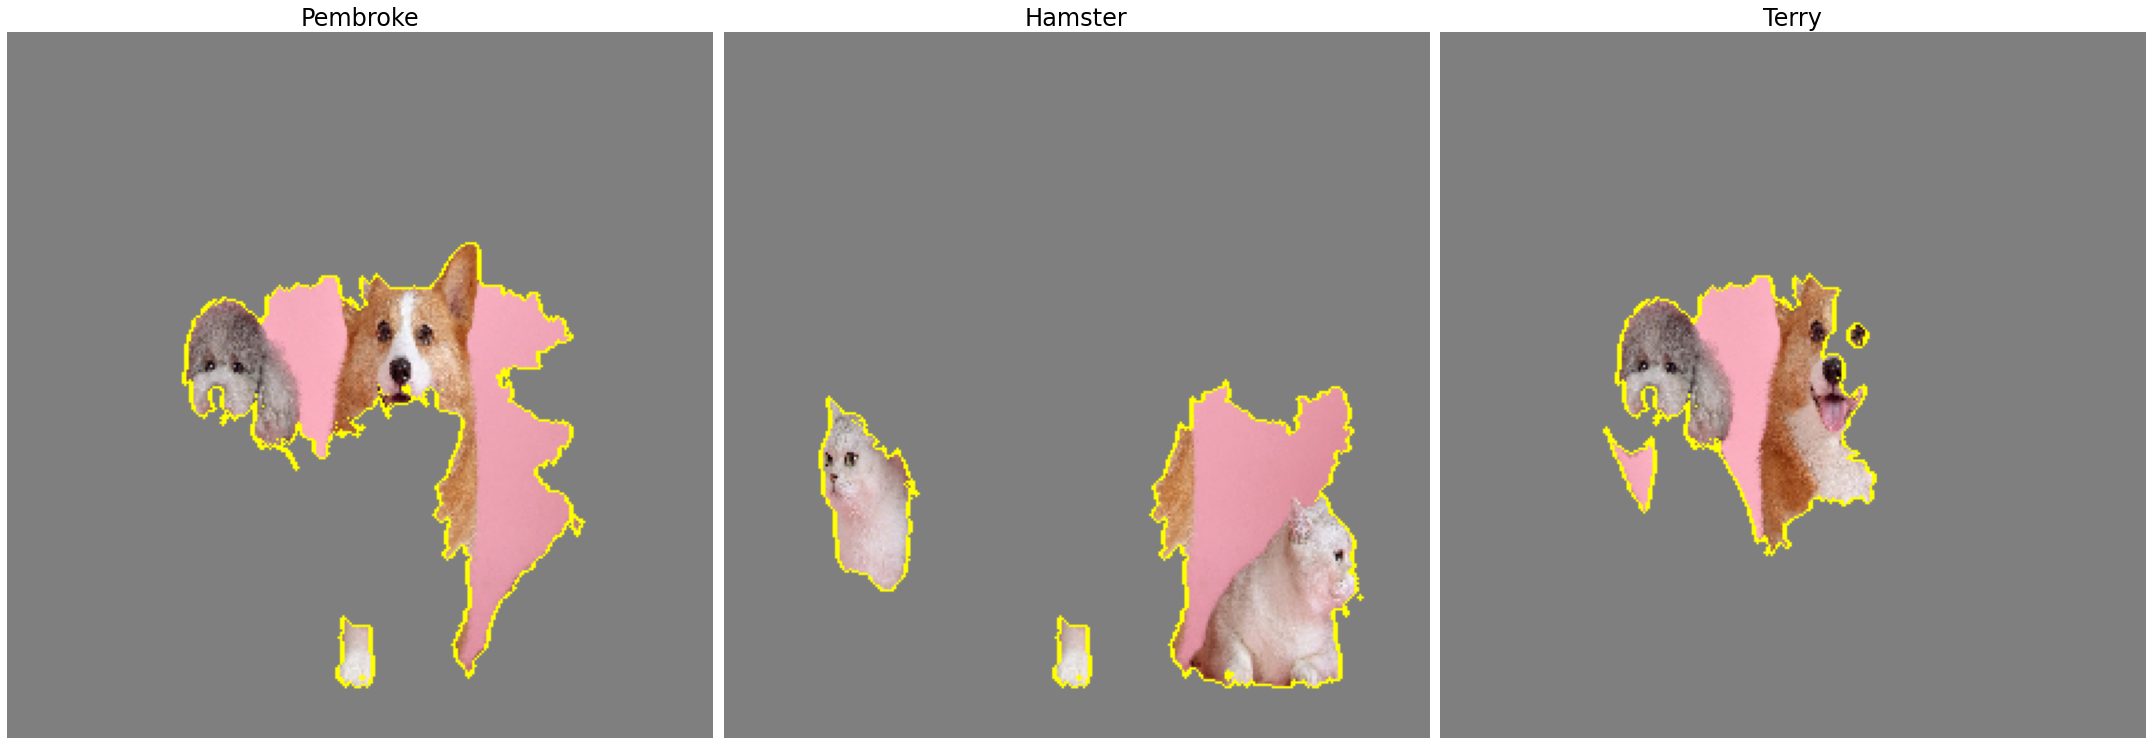

In [7]:
fig = plt.figure(figsize=(30, 30))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)

tmp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
plt.axis('off')
plt.title("Pembroke",fontsize=24)
plt.tight_layout()

fig.add_subplot(rows, columns, 2)

tmp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
plt.axis('off')
plt.title("Hamster", fontsize=24)
plt.tight_layout()

fig.add_subplot(rows, columns, 3)

tmp, mask = explanation.get_image_and_mask(explanation.top_labels[2], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
plt.axis('off')
plt.title("Terry", fontsize=24)

plt.savefig('./topclass1.png', bbox_inches='tight')

View superpixels that positively contributing to the label predictions with the rest of the image present.

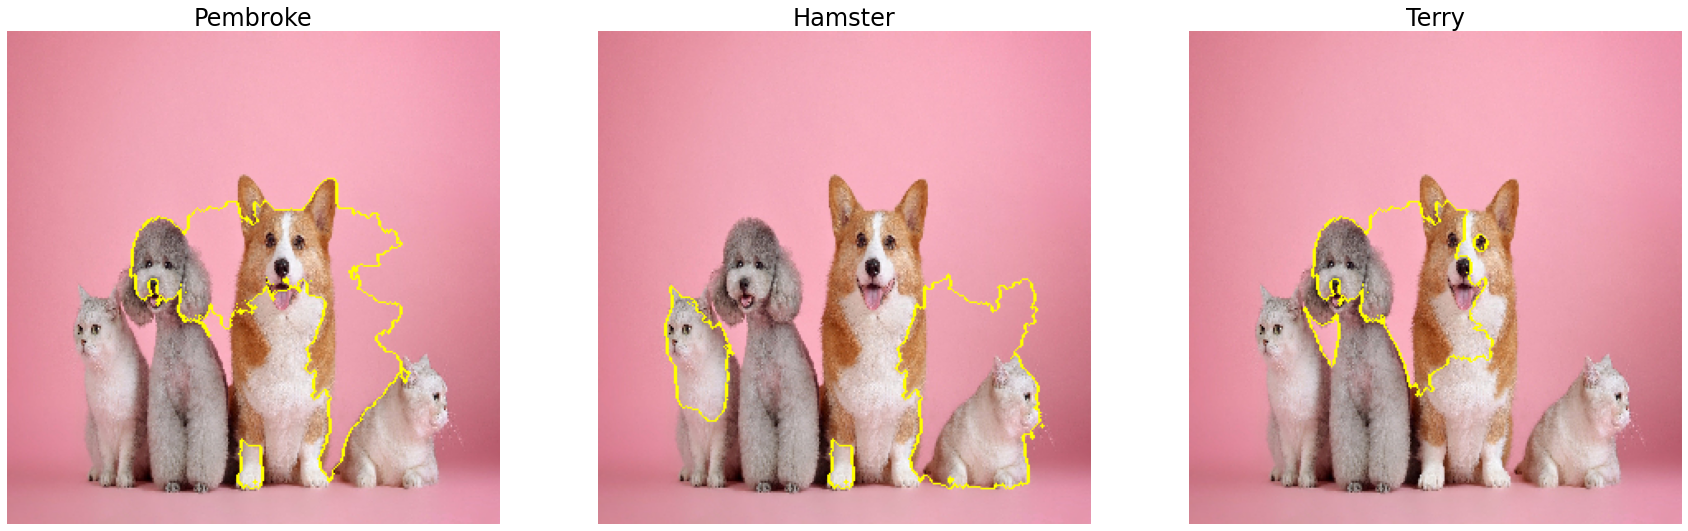

In [8]:
# Predicted classes are pembroke, hamster, teddy, cardigan, norwich_terrier

fig = plt.figure(figsize=(30, 30))
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)

tmp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
plt.axis('off')
plt.title("Pembroke", fontsize=24)

fig.add_subplot(rows, columns, 2)

tmp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
plt.axis('off')
plt.title("Hamster", fontsize=24)

fig.add_subplot(rows, columns, 3)

tmp, mask = explanation.get_image_and_mask(explanation.top_labels[2], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
plt.axis('off')
plt.title("Terry", fontsize=24)

plt.savefig('./topclass2.png', bbox_inches='tight')

Superpixels that positively or negatively contribute to the label prediction. Positive in green, negative in red.

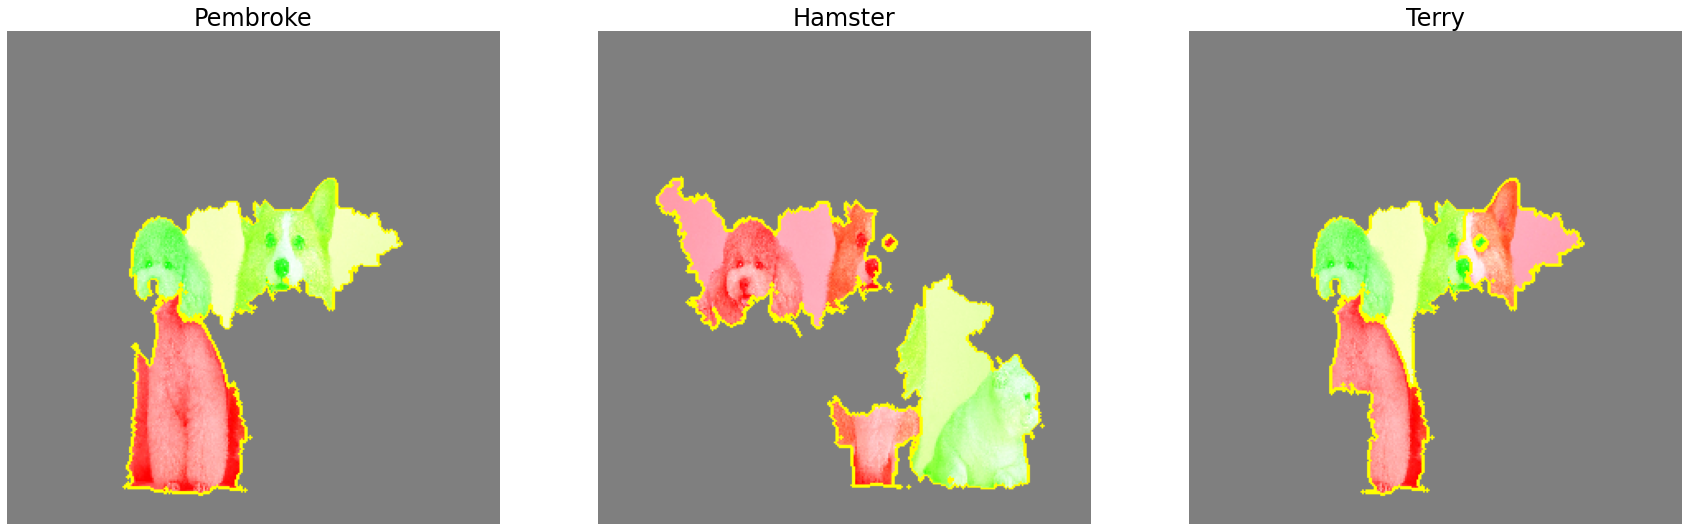

In [9]:
fig = plt.figure(figsize=(30, 30))
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)

tmp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
plt.axis('off')
plt.title("Pembroke", fontsize=24)

fig.add_subplot(rows, columns, 2)

tmp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
plt.axis('off')
plt.title("Hamster", fontsize=24)

fig.add_subplot(rows, columns, 3)

tmp, mask = explanation.get_image_and_mask(explanation.top_labels[2], positive_only=False, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
plt.axis('off')
plt.title("Terry", fontsize=24)

plt.savefig('./topclass3.png', bbox_inches='tight')

Explanation with minimum weight of the superpixels

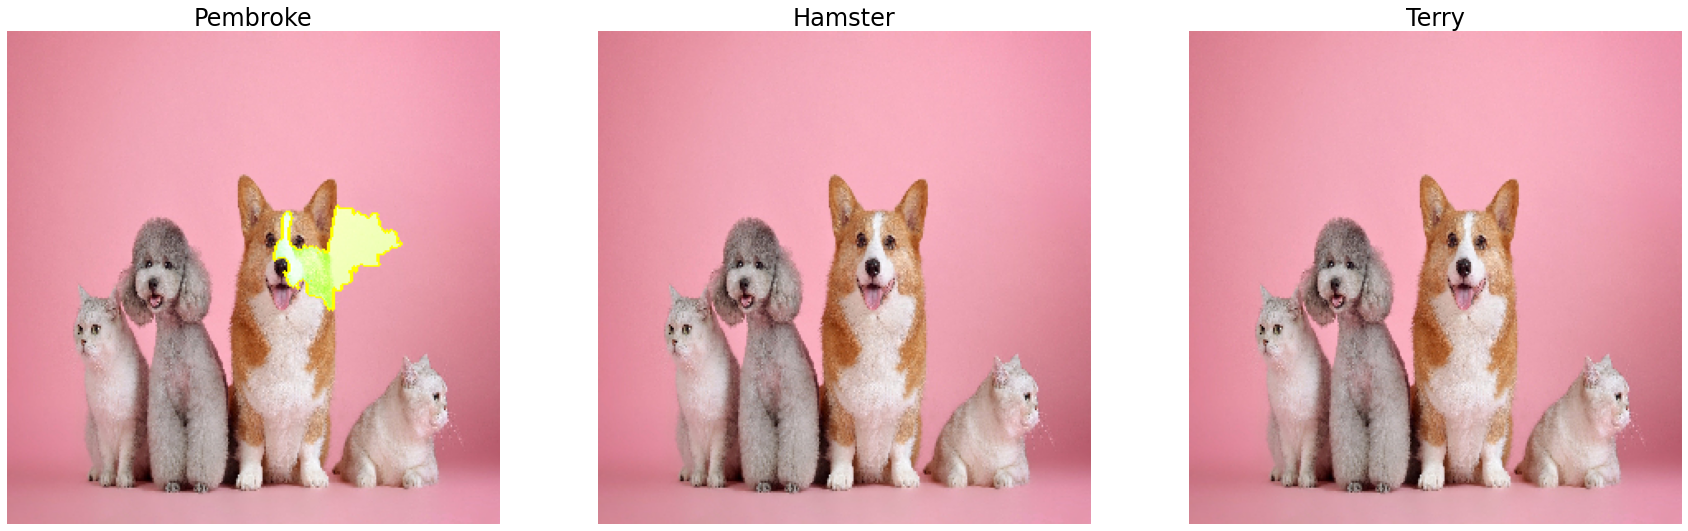

In [10]:
fig = plt.figure(figsize=(30, 30))
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)

tmp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
plt.axis('off')
plt.title("Pembroke", fontsize=24)

fig.add_subplot(rows, columns, 2)

tmp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=5, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
plt.axis('off')
plt.title("Hamster", fontsize=24)

fig.add_subplot(rows, columns, 3)

tmp, mask = explanation.get_image_and_mask(explanation.top_labels[2], positive_only=False, num_features=5, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(tmp / 2 + 0.5, mask))
plt.axis('off')
plt.title("Terry", fontsize=24)

plt.savefig('./topclass4.png', bbox_inches='tight')

This concludes the review of explaining an image classifier with LimeImageExplainer.